# Home Loan Approval/Denial

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import (
    make_column_transformer,
    make_column_selector,
    ColumnTransformer,
)

from sklearn.metrics import classification_report

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.svm import SVC
from sklearn.feature_selection import RFE

from sklearn import set_config

set_config(display="diagram")

#### Auxiliary variables

In [3]:
filename_input = "data-hdma-eastbay-2019-2022-processed"
filename_output = "data-hdma-eastbay-2019-2022-sklearn"

#### Loading the processed data

In [4]:
df = pd.read_csv(f"../../{filename_input}.csv", index_col=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222872 entries, 0 to 222871
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   debt_to_income_ratio_df            222872 non-null  float64
 1   property_value                     222872 non-null  float64
 2   loan_term                          222872 non-null  float64
 3   loan_to_value_ratio                222872 non-null  float64
 4   loan_amount                        222872 non-null  float64
 5   income                             222872 non-null  float64
 6   tract_minority_population_percent  222872 non-null  float64
 7   tract_to_msa_income_percentage     222872 non-null  float64
 8   tract_population                   222872 non-null  float64
 9   tract_one_to_four_family_homes     222872 non-null  float64
 10  tract_median_age_of_housing_units  222872 non-null  float64
 11  tract_owner_occupied_units         222872 no

## 3. Preparing for modeling

### 3.1. Test features

In [6]:
df["sqrt_income"] = df["income"].apply(np.sqrt)
df["sqrt_property_value"] = df["property_value"].apply(np.sqrt)
df["sqrt_loan_amount"] = df["loan_amount"].apply(np.sqrt)

### 3.2. Lists of feature names

In [7]:
tract_features = [x for x in df.columns if x.startswith("tract_")]

numerical_loan_features = [
    "debt_to_income_ratio",
    "debt_to_income_ratio_df",
    "loan_term",
    "loan_to_value_ratio",
]
numerical_currency_features = ["property_value", "income", "loan_amount"]
numerical_sqrt_currency_features = [
    "sqrt_income",
    "sqrt_property_value",
    "sqrt_loan_amount",
]
categorical_applicant_features = [
    "applicant_sex",
    "applicant_race",
    "applicant_ethnicity",
    "applicant_age",
]
categorical_coapplicant_features = [
    "coapplicant_sex",
    "coapplicant_race",
    "coapplicant_ethnicity",
    "coapplicant_age",
]
categorical_loan_features = [
    "conforming_loan_limit",
    "occupancy_type",
    # "hoepa_status",
    "lien_status",
    "loan_purpose",
    "loan_type",
]
binary_features = [
    "applicant_age_above_62",
    "interest_only_payment",
    "business_or_commercial_purpose",
    "open-end_line_of_credit",
]

derived_features = [
    "derived_sex",
    "derived_race",
    "derived_ethnicity",
    "derived_loan_product_type",
]

target_related_features = ["denial_reason"]

target_feature = "application_outcome"

### 3.3. X,y

In [8]:
X = df[
    numerical_loan_features
    + numerical_currency_features
    + numerical_sqrt_currency_features
    # + categorical_applicant_features
    # + categorical_coapplicant_features
    + categorical_loan_features
    + binary_features
    # + derived_features
]
y = df[target_feature]

### 3.4. train/test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

### 3.5. Column transformers

In [10]:
categorical_columns = X.select_dtypes(include=object).columns
numerical_columns = X.select_dtypes(include=float).columns

print(categorical_columns)
print(numerical_columns)

Index(['conforming_loan_limit', 'occupancy_type', 'lien_status',
       'loan_purpose', 'loan_type', 'applicant_age_above_62',
       'interest_only_payment', 'business_or_commercial_purpose',
       'open-end_line_of_credit'],
      dtype='object')
Index(['debt_to_income_ratio', 'debt_to_income_ratio_df', 'loan_term',
       'loan_to_value_ratio', 'property_value', 'income', 'loan_amount',
       'sqrt_income', 'sqrt_property_value', 'sqrt_loan_amount'],
      dtype='object')


In [11]:
def main_column_transformer():
    return ColumnTransformer(
        [
            ("ohe", OneHotEncoder(sparse_output=False), categorical_columns),
            ("scaler", StandardScaler(), numerical_columns),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

## 4. Modeling

In [12]:
def get_info(model):
    print(f"train score = {model.score(X_train, y_train)}")
    print(f"test score = {model.score(X_test, y_test)}")

### 4.1. Testing models

#### 4.1.0. Baseline

In [13]:
baseline = DummyClassifier().fit(X_train, y_train)
get_info(baseline)

train score = 0.6592462021665277
test score = 0.6592384313960097


#### 4.1.1. LogisticRegression

In [14]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)
pipeline.fit(X_train, y_train)
get_info(pipeline)
print(classification_report(y_test, pipeline.predict(X_test)))

train score = 0.7775334914428562
test score = 0.7777063204809906
              precision    recall  f1-score   support

    Approved       0.79      0.90      0.84     44078
      Denied       0.74      0.53      0.62     22784

    accuracy                           0.78     66862
   macro avg       0.77      0.72      0.73     66862
weighted avg       0.77      0.78      0.77     66862



#### 4.1.2. K-Nearest Neighbors (KNN)

In [23]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", KNeighborsClassifier(n_neighbors=10, n_jobs=-1)),
    ]
)
pipeline.fit(X_train, y_train)
get_info(pipeline)
print(classification_report(y_test, pipeline.predict(X_test)))

train score = 0.8160887122620345
test score = 0.7908079327570219
              precision    recall  f1-score   support

    Approved       0.78      0.95      0.86     44078
      Denied       0.82      0.49      0.62     22784

    accuracy                           0.79     66862
   macro avg       0.80      0.72      0.74     66862
weighted avg       0.80      0.79      0.77     66862



#### 4.1.3. Decision Tree

In [16]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", DecisionTreeClassifier(max_depth=3)),
    ]
)
pipeline.fit(X_train, y_train)
get_info(pipeline)
print(classification_report(y_test, pipeline.predict(X_test)))

train score = 0.7795590026280367
test score = 0.7800095719541743
              precision    recall  f1-score   support

    Approved       0.76      0.97      0.85     44078
      Denied       0.88      0.41      0.56     22784

    accuracy                           0.78     66862
   macro avg       0.82      0.69      0.71     66862
weighted avg       0.80      0.78      0.75     66862



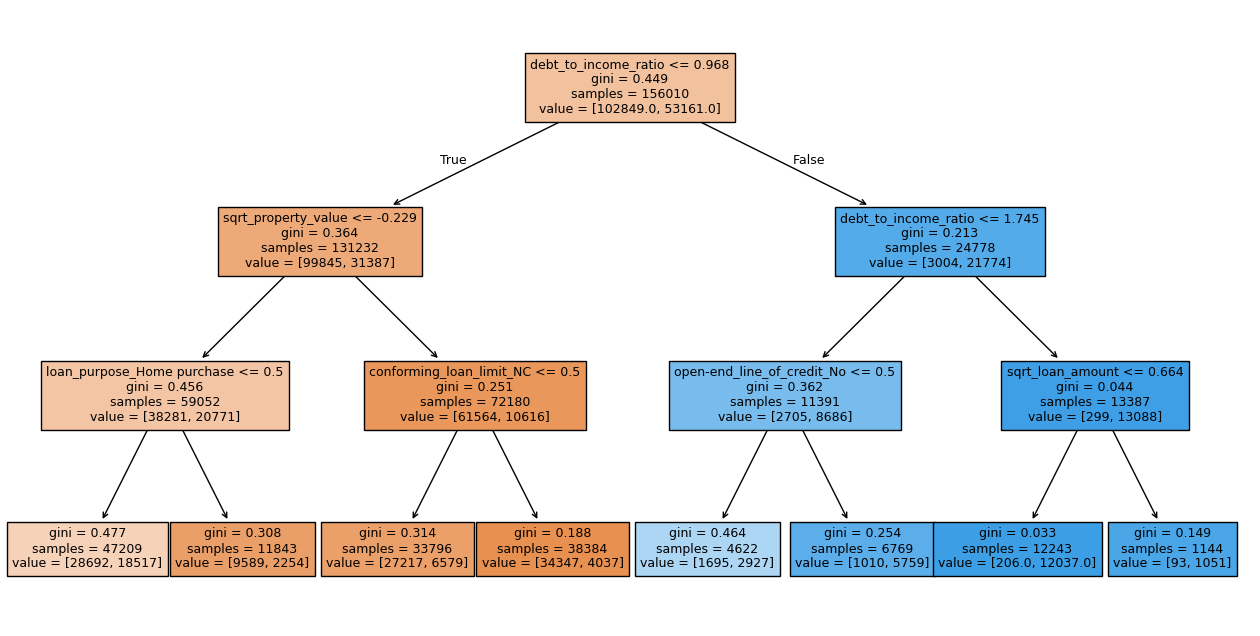

In [17]:
f, ax = plt.subplots(figsize=(16, 8))
plot_tree(
    pipeline.named_steps["model"],
    feature_names=pipeline[0].get_feature_names_out(),
    fontsize=9,
    filled=True,
    ax=ax,
)
plt.show()

### 4.2. Searching hyperparameters

#### 4.2.1. LogisticRegression

In [20]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", LogisticRegression(max_iter=10000)),
    ]
)
grid_lr = GridSearchCV(
    pipeline,
    param_grid={
        "model__C": 10.0 ** np.array([-4, -3, -2, -1, 0]),
    },
    verbose=4,
    cv=3,
    n_jobs = -1,
).fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END ...................model__C=0.0001;, score=0.773 total time=   0.9s
[CV 2/3] END ...................model__C=0.0001;, score=0.773 total time=   0.8s
[CV 3/3] END ...................model__C=0.0001;, score=0.772 total time=   0.8s
[CV 1/3] END ....................model__C=0.001;, score=0.779 total time=   1.1s
[CV 2/3] END ....................model__C=0.001;, score=0.778 total time=   1.1s
[CV 3/3] END ....................model__C=0.001;, score=0.778 total time=   1.1s
[CV 1/3] END .....................model__C=0.01;, score=0.778 total time=   1.2s
[CV 2/3] END .....................model__C=0.01;, score=0.778 total time=   1.2s
[CV 3/3] END .....................model__C=0.01;, score=0.777 total time=   1.2s
[CV 1/3] END ......................model__C=0.1;, score=0.778 total time=   1.2s
[CV 2/3] END ......................model__C=0.1;, score=0.778 total time=   1.2s
[CV 3/3] END ......................model__C=0.1;,

In [21]:
get_info(grid_lr)

train score = 0.7782065252227421
test score = 0.778424217044061


#### 4.2.3. Decision Tree

In [22]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", DecisionTreeClassifier()),
    ]
)
grid_dt = GridSearchCV(
    pipeline,
    param_grid={
        "model__criterion": ["gini", "entropy", "log_loss"],
        "model__max_depth": [4, 8, 12, 16, 20],
        # 'model__min_samples_split': [2, 4, 8, 16],
        # 'model__min_samples_leaf': [1, 2, 4, 8, 16],
    },
    verbose=4,
    cv=3,
    n_jobs=-1,
).fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END model__criterion=gini, model__max_depth=4;, score=0.786 total time=   1.1s
[CV 2/3] END model__criterion=gini, model__max_depth=4;, score=0.786 total time=   1.1s
[CV 3/3] END model__criterion=gini, model__max_depth=4;, score=0.787 total time=   1.1s
[CV 1/3] END model__criterion=gini, model__max_depth=8;, score=0.797 total time=   1.4s
[CV 2/3] END model__criterion=gini, model__max_depth=8;, score=0.800 total time=   1.6s
[CV 3/3] END model__criterion=gini, model__max_depth=8;, score=0.799 total time=   1.5s
[CV 1/3] END model__criterion=gini, model__max_depth=12;, score=0.797 total time=   1.8s
[CV 2/3] END model__criterion=gini, model__max_depth=12;, score=0.798 total time=   1.8s
[CV 3/3] END model__criterion=gini, model__max_depth=12;, score=0.797 total time=   1.8s
[CV 1/3] END model__criterion=gini, model__max_depth=16;, score=0.788 total time=   2.1s
[CV 2/3] END model__criterion=gini, model__max_depth=16

In [51]:
grid_dt.best_params_

{'model__criterion': 'log_loss', 'model__max_depth': 10}

In [53]:
get_info(grid_dt)
print(classification_report(y_test, grid_dt.predict(X_test)))

train score = 0.8077238638548812
test score = 0.8000059824713589
              precision    recall  f1-score   support

    Approved       0.79      0.95      0.86     44078
      Denied       0.84      0.51      0.64     22784

    accuracy                           0.80     66862
   macro avg       0.81      0.73      0.75     66862
weighted avg       0.81      0.80      0.79     66862



#### 4.2.4. SVM

In [30]:
_, X_small, _, y_small = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
X_small = X_small.reset_index(drop=True)
y_small = y_small.reset_index(drop=True)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, test_size=0.30, stratify=y_small, random_state=2)

In [31]:
X_small.shape

(22288, 19)

In [33]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", SVC()),
    ]
)
grid_svm = GridSearchCV(
    pipeline,
    param_grid={
        "model__C": 10.0 ** np.array([-1, 0, 1, 2]),
    },
    verbose=4,
    cv=3,
    n_jobs=-1,
).fit(X_small_train, y_small_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[CV 1/3] END ......................model__C=1.0;, score=0.788 total time=   7.0s
[CV 3/3] END ......................model__C=0.1;, score=0.782 total time=   7.4s
[CV 1/3] END ......................model__C=0.1;, score=0.782 total time=   7.5s
[CV 2/3] END ......................model__C=0.1;, score=0.782 total time=   7.5s
[CV 2/3] END ......................model__C=1.0;, score=0.792 total time=   7.3s
[CV 3/3] END ......................model__C=1.0;, score=0.790 total time=   7.4s
[CV 2/3] END .....................model__C=10.0;, score=0.794 total time=   8.3s
[CV 1/3] END .....................model__C=10.0;, score=0.789 total time=   8.4s
[CV 3/3] END .....................model__C=10.0;, score=0.795 total time=   7.6s
[CV 1/3] END ....................model__C=100.0;, score=0.782 total time=  12.4s
[CV 2/3] END ....................model__C=100.0;, score=0.785 total time=  11.8s
[CV 3/3] END ....................model__C=100.0;, score=0.783 total time=  12.2s


In [34]:
print(grid_svm.score(X_small_test, y_small_test))
print(grid_svm.score(X_test, y_test))
print(grid_svm.score(X_train, y_train))

0.7928817107821146
0.802234453052556
0.7967822575475931
